# Depresjon - basic feature engineering

This notebook aims to recreate feature engineering for Depresjon dataset from paper "Comparison of Night, Day and 24 h Motor Activity Data for the Classification of Depressive Episodes".

## Libraries

In [1]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

## Data loading

First, we have to load the data.

In [2]:
data_dir = "./depresjon_data"
condition_dir = os.path.join(data_dir, "condition")
control_dir = os.path.join(data_dir, "control")
scores_file = os.path.join(data_dir, "scores.csv")

`condition` and `control` directories contain CSV files with measurements, one file per person. For example, `condition_1.csv` contains measurements for patient 1 diagnosed with depression.

Those files are read into a list of dataframes, since this makes them easy to process later.

In [3]:
conditions = [pd.read_csv(os.path.join(condition_dir, filename)) for filename in os.listdir(condition_dir)]
controls = [pd.read_csv(os.path.join(control_dir, filename)) for filename in os.listdir(control_dir)]

In [4]:
conditions[0].head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


The `scores.csv` file contains static information about patients.

In [5]:
static_data = pd.read_csv(scores_file)
static_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


## Exploratory data analysis

We have the data loaded, now we can explore it: check number of measurements, number of columns, their types, missing values etc. First the data for time series will be checked, then for the static data.

### Number of patients

Condition number: 23
Control number: 32


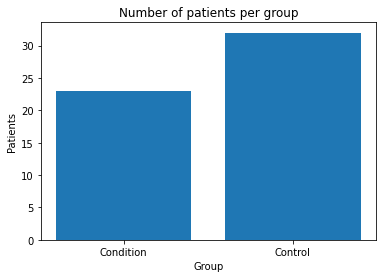

In [6]:
xs = ["Condition", "Control"]
ys = [len(conditions), len(controls)]

print(f"Condition number: {len(conditions)}")
print(f"Control number: {len(controls)}")

plt.bar(xs, ys)
plt.xlabel("Group")
plt.ylabel("Patients")
plt.title("Number of patients per group")
plt.show()

We definitely have quite heavy imbalance, the control group being about 50% larger than the condition group. This influences many metrics and should be taken into consideration.

### Measurements number

In [7]:
condition_rows = pd.Series([len(df) for df in conditions])
condition_rows.describe()

count       23.000000
mean     23987.652174
std       5748.966513
min      19299.000000
25%      21463.000000
50%      21648.000000
75%      23117.000000
max      41847.000000
dtype: float64

In [8]:
control_rows = pd.Series([len(df) for df in controls])
control_rows.describe()

count       32.000000
mean     31874.687500
std      12228.922745
min      20490.000000
25%      22258.500000
50%      28257.000000
75%      33683.000000
max      65407.000000
dtype: float64

We have greatly varying number of measurements for both condition and control group. In general measurements for control group are longer, but also more varied (both mean and standard deviation are higher). For fair assessment, where each patient gets the same chance to influence the model, the measurements should be of equal length for all cases. However, for calculating aggregations (e.g. mean / median value) this may not be necessary, since they typically reduce the data to a single number.

### Columns and types

In [9]:
conditions[0].head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [10]:
conditions[0].dtypes

timestamp    object
date         object
activity      int64
dtype: object

For measurement files we have 3 columns:
- timestamp with precise measurement date and time, with 1 minute measurement resolution
- date, information already included in the timestamp
- activity, the time series value

Data types of columns are definitely wrong - `timestamp` should be a proper timestamp and the `date` column is redundant. This will be fixed in the preprocessing section.

### Missing values

In [11]:
condition_NaNs = pd.Series([df["activity"].isna().sum() for df in conditions])
condition_NaNs.mean()

0.0

In [12]:
control_NaNs = pd.Series([df["activity"].isna().sum() for df in controls])
control_NaNs.mean()

0.0

We have exactly 0 missing values for the dependent variable, activity. This means that the data was accurately gathered for all patients for the entire duration of measurement period.

### Statis data

In [13]:
static_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [14]:
static_data.dtypes

number        object
days           int64
gender         int64
age           object
afftype      float64
melanch      float64
inpatient    float64
edu           object
marriage     float64
work         float64
madrs1       float64
madrs2       float64
dtype: object

In [15]:
for col in static_data.columns:
    print(col, static_data[col].unique())

number ['condition_1' 'condition_2' 'condition_3' 'condition_4' 'condition_5'
 'condition_6' 'condition_7' 'condition_8' 'condition_9' 'condition_10'
 'condition_11' 'condition_12' 'condition_13' 'condition_14'
 'condition_15' 'condition_16' 'condition_17' 'condition_18'
 'condition_19' 'condition_20' 'condition_21' 'condition_22'
 'condition_23' 'control_1' 'control_2' 'control_3' 'control_4'
 'control_5' 'control_6' 'control_7' 'control_8' 'control_9' 'control_10'
 'control_11' 'control_12' 'control_13' 'control_14' 'control_15'
 'control_16' 'control_17' 'control_18' 'control_19' 'control_20'
 'control_21' 'control_22' 'control_23' 'control_24' 'control_25'
 'control_26' 'control_27' 'control_28' 'control_29' 'control_30'
 'control_31' 'control_32']
days [11 18 13  7  5  9 14 12 16  8 20]
gender [2 1]
age ['35-39' '40-44' '45-49' '25-29' '50-54' '20-24' '60-64' '55-59' '30-34'
 '65-69']
afftype [ 2.  1.  3. nan]
melanch [ 2. nan  1.]
inpatient [ 2.  1. nan]
edu ['6-10' '11-15' '16-2

Observations:
- all data types seem correct
- `number` is essentially an index for patients and should not be used as a feature
- `days` indicate the number of data collection days, but this information is already included in the time series timestamps
- `gender` is correct, but doesn't follow the usual convention of 0-1 values for binary features
- `age` should be preprocessed to integers (e.g. `0` for <50 years, `1` for >= 50 years) for classification
- `afftype` and `melanch` indicate the clinical state observations for depressed patients and are NaN for non-depressed controls
- `edu`, `marriage` and `work` explain socioeconomic status of the patient
- `madrs1` and `madrs2` are MADRS score for patients with condition at the beginning and at the end of measurements; they are not used for classification, but they could be used as regression targets

## Feature engineering

In the paper several steps of feature engineering are introduced. They need to be performed, as the typical models for tabular data like Random Forest are used. This approach allows usage of classical ML algorithms on time series data, while also indirectly incorporating time dependencies in form of features derived from the signal.

### Preprocessing

**Warning**: I've found out that the paper is actually inconsistent in what it says and does in the preprocessing. It states that:
"For the pre-processing stage, the next step are proposed. Since the total amount of data recorded for each subject is different, a new subset of data is extracted, adjusting the number of observations to be equal for each subject. Theh, from the new set of data, a segmentation is applied to form one hour data intervals. This segmentation allowed the classification of depressive episodes per hour.

Therefore, based on the hourly segmentation, three different subsets are constructed; night motor activity (from 21 to 7 h taking into account the sunrise standard hours) [21], day motor activity (from 8 to 20 h) and finally all day motor activity with the total day hours. The number of observations contained in each dataset is shown in Table 1. After separated the data into day, night and 24 h data were cleaned from missing data."

According to this, we should:
- trim observations to the length of the shortest one, forming "new set of data" with same number of observations per subject
- segment into 1-hour intervals, calculating average activity
- create night dataset, day dataset and dataset with all observations

According to the paper, they got the following number of hourly observations:
- day: 14168
- night: 11945
- full data: 26113

But this number is wrong. This is approximately the number of raw observations in the dataset, not number of hour segments. In addition, to make sure that night and day data has the same length, it should be trimmed to the same length after splitting. Corrected process:
- segment data for each patient into 1-hour intervals, calculating average activity
- create night dataset, day dataset and dataset with all observations
- trim observations in each dataset to the length of the shortest one

This way, we arrive at the following sequences lengths:
- day: 9845
- night: 7865
- full data: 17710

First, correct the data type of `timestamp` column and drop the redundant `date` column.

In [16]:
for df in (conditions + controls):
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")

for df in (conditions + controls):
    if "date" in df.columns:
        df.drop("date", axis=1, inplace=True)

conditions[0].head()

,timestamp,activity
0,2003-05-07 12:00:00,0
1,2003-05-07 12:01:00,143
2,2003-05-07 12:02:00,0
3,2003-05-07 12:03:00,20
4,2003-05-07 12:04:00,166


In [17]:
controls[1].dtypes

timestamp    datetime64[ns]
activity              int64
dtype: object

Next, group by hour and calculate mean hourly activity.

In [18]:
def group_by_hour(df: pd.DataFrame) -> pd.DataFrame:
    # group by hour, calculate means
    timestamps = df["timestamp"]
    group_by_cols = [timestamps.dt.year, timestamps.dt.month, timestamps.dt.day, timestamps.dt.hour]
    grouped = df.groupby(group_by_cols).mean()

    # recreate flat index for 2D table
    grouped.index = grouped.index.to_flat_index()
    datetime_index_df = pd.DataFrame(grouped.index.values.tolist(), columns=["year", "month", "day", "hour"])
    datetime_index = pd.to_datetime(datetime_index_df)

    # add back the datetime information
    grouped.reset_index(inplace=True)
    grouped["datetime"] = datetime_index
    grouped.drop("index", axis=1, inplace=True)

    # change column order for readability
    grouped = grouped.reindex(["datetime", "activity"], axis=1)
    
    return grouped

In [19]:
conditions_preprocessed = [group_by_hour(df) for df in conditions]
controls_preprocessed = [group_by_hour(df) for df in controls]

Lastly, create separate night and day datasets in addition to the whole dataset.

In [20]:
def get_night_day_division(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    night_df = df.loc[(df["datetime"].dt.hour >= 21) | (df["datetime"].dt.hour < 8)]
    day_df = df.loc[(df["datetime"].dt.hour >= 8) & (df["datetime"].dt.hour < 21)]
    return night_df, day_df

In [21]:
conditions_night = []
conditions_day = []

controls_night = []
controls_day = []

for df in conditions_preprocessed:
    night_df, day_df = get_night_day_division(df)
    conditions_night.append(night_df)
    conditions_day.append(day_df)

for df in controls_preprocessed:
    night_df, day_df = get_night_day_division(df)
    controls_night.append(night_df)
    controls_day.append(day_df)

Trim to the same number of 1-hour segments, so we have equal length sequences for night, day and all data.

In [22]:
min_length_night = min([len(df) for df in conditions_night + controls_night])
min_length_day = min([len(df) for df in conditions_day + controls_day])
min_length_all = min(min_length_night, min_length_day)

conditions_trimmed = {
    "night": [df[:min_length_night] for df in conditions_night],
    "day": [df[:min_length_day] for df in conditions_day],
    "all": [df[:min_length_all] for df in conditions_night + conditions_day]
}

controls_trimmed = {
    "night": [df[:min_length_night] for df in controls_night],
    "day": [df[:min_length_day] for df in controls_day],
    "all": [df[:min_length_all] for df in controls_night + controls_day]
}

Let's check the number of hour segments.

In [23]:
night_observations = sum([len(df) for df in conditions_trimmed["night"] + controls_trimmed["night"]])
day_observations = sum([len(df) for df in conditions_trimmed["day"] + controls_trimmed["day"]])
all_observations= sum([len(df) for df in conditions_trimmed["all"] + controls_trimmed["all"]])

print(f"Day: {day_observations}")
print(f"Night: {night_observations}")
print(f"Full data: {day_observations + night_observations}")

Day: 9845
Night: 7865
Full data: 17710


As you can see, the number of segments is very different than stated in the paper. However, that was probably just a mistake in specifying the table contents and authors got similiar numbers of actual hourly segments as here.

Before further processing it will come in handy to work on regular Numpy arrays instead of lists of DataFrames. We will have 1 row per patient, with columns indicating measurements (short and wide matrix).

In [24]:
X_night = [df["activity"].values for df in conditions_trimmed["night"]] + \
          [df["activity"].values for df in controls_trimmed["night"]]
X_night = np.vstack(X_night)

y_night = np.zeros(X_night.shape[0])
y_night[:len(conditions_trimmed["night"]) + 1] = 1


X_day = [df["activity"].values for df in conditions_trimmed["day"]] + \
        [df["activity"].values for df in controls_trimmed["day"]]
X_day = np.vstack(X_day)

y_day = np.zeros(X_day.shape[0])
y_day[:len(conditions_trimmed["day"]) + 1] = 1


X_all = [df["activity"].values for df in conditions_trimmed["all"]] + \
        [df["activity"].values for df in controls_trimmed["all"]]
X_all = np.vstack(X_all)

y_all = np.zeros(X_all.shape[0])
y_all[:len(conditions_trimmed["all"]) + 1] = 1

Make sure that the data is correct:

In [25]:
X_night[:5]

array([[4.15333333e+01, 3.24500000e+01, 1.48733333e+02, 8.00000000e+00,
        4.08333333e+00, 7.06666667e+00, 4.03333333e+00, 1.22166667e+01,
        9.66666667e-01, 1.00000000e+01, 1.37000000e+01, 1.20050000e+02,
        4.65166667e+01, 6.78666667e+01, 6.97000000e+01, 2.22500000e+01,
        1.10166667e+01, 2.08333333e+00, 1.26500000e+01, 4.51666667e+00,
        6.43333333e+00, 5.66666667e+00, 1.78116667e+02, 5.82000000e+01,
        3.67000000e+01, 1.00616667e+02, 9.86333333e+01, 7.71666667e+00,
        3.28333333e+00, 3.70000000e+00, 5.83333333e-01, 1.96666667e+00,
        1.77833333e+01, 4.76666667e+01, 7.99666667e+01, 8.54833333e+01,
        2.76666667e+00, 9.16666667e-01, 4.08333333e+00, 6.51666667e+00,
        2.03666667e+01, 7.95000000e+00, 1.37333333e+01, 1.08666667e+01,
        5.21500000e+01, 4.39666667e+01, 1.11233333e+02, 2.76666667e+00,
        2.66666667e+00, 1.24500000e+01, 5.25000000e+00, 9.81666667e+00,
        9.68333333e+00, 9.68333333e+00, 9.86666667e+00, 1.402000

In [26]:
y_night

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

There seem to be no missing values, despite what's described in the paper. There is a possibility that dataset available online has already been cleaned in this regard.

Next we standardize the data, i.e. subtract mean and divide by standard deviation. I assume that standardization is done separately for all 3 sets of data, though this has not been specified in the paper.

In [27]:
X_night_standardized = (X_night - X_night.mean()) / X_night.std()
X_day_standardized = (X_day - X_day.mean()) / X_day.std()
X_all_standardized = (X_all - X_all.mean()) / X_all.std()

### Time domain

Time features are extracted according to the article:
- `mean`, `median`, `stddev`, `variance`, `kurtosis`, `minimum`, `maximum` - quite self explanatory statistical features
- `coeff_of_var` - coefficient of variation, the ratio of the biased standard deviation to the mean
- `iqr` - interquartile range, difference between 75 and 25 percentile (3rd and 1st quartile)
- `trimmed_mean` - alternatively truncated mean, mean of the values where the most extreme values (from both ends) are not used; since the article doesn't specify this, I assume that the popular 10% trim percentage is used

Data is saved as a DataFrame, since some machine learning models can provide additional insight when using named columns.

In [ ]:
from scipy.stats import iqr, kurtosis, trim_mean, variation

In [ ]:
def extract_features(X: np.ndarray) -> pd.DataFrame:
    features = {
        "mean": X.mean(axis=1),
        "median": np.median(X, axis=1),
        "stddev": X.std(axis=1),
        "variance": np.var(X, axis=1),
        "kurtosis": kurtosis(X, axis=1),
        "coeff_of_var": variation(X, axis=1),
        "iqr": iqr(X, axis=1),
        "minimum": X.min(axis=1),
        "maximum": X.max(axis=1),
        "trimmed_mean": trim_mean(X, proportiontocut=0.1, axis=1)
    }
    return pd.DataFrame(features)

In [ ]:
X_night_features = extract_features(X_night_standardized)
X_day_features = extract_features(X_day_standardized)
X_all_features = extract_features(X_all_standardized)

### Frequency domain

In [31]:
f_frames = []

for c_i, c in enumerate(conditions, start=1):
    c_copy = c.copy()
    c['number'] = f'condition_{c_i}'
    f_frames.append(c_copy)
    
for c_i, c in enumerate(controls, start=1):
    c_copy = c.copy()
    c['number'] = f'control_{c_i}'
    f_frames.append(c_copy)

f_df = pd.concat(f_frames)
f_df.reset_index()

f_df['date'] = f_df.apply(lambda r: r['timestamp'].date(), axis=1)
f_df['hour'] = f_df.apply(lambda r: r['timestamp'].hour, axis=1)

f_df.head()

,timestamp,activity,number,date,hour
0,2003-05-07 12:00:00,0,condition_1,2003-05-07,12
1,2003-05-07 12:01:00,143,condition_1,2003-05-07,12
2,2003-05-07 12:02:00,0,condition_1,2003-05-07,12
3,2003-05-07 12:03:00,20,condition_1,2003-05-07,12
4,2003-05-07 12:04:00,166,condition_1,2003-05-07,12


In [32]:
f_df.drop('timestamp', axis=1, inplace=True)
f_df.head()

,activity,number,date,hour
0,0,condition_1,2003-05-07,12
1,143,condition_1,2003-05-07,12
2,0,condition_1,2003-05-07,12
3,20,condition_1,2003-05-07,12
4,166,condition_1,2003-05-07,12


In [33]:
f_df_segments = f_df.groupby(['number', 'date', 'hour'])
f_df_segments

In [34]:
f_df_grouped = f_df_segments['activity'].apply(list).to_frame()
f_df_grouped

activity
number      date       hour                                                   
condition_1 2003-05-07 12    [0, 143, 0, 20, 166, 160, 17, 646, 978, 306, 2...
                       13    [306, 286, 12, 0, 130, 160, 296, 317, 338, 277...
                       14    [0, 0, 21, 67, 88, 43, 485, 568, 550, 328, 64,...
                       15    [38, 85, 0, 38, 52, 49, 338, 52, 70, 0, 0, 500...
                       16    [15, 0, 0, 646, 587, 439, 197, 425, 361, 338, ...
...                                                                        ...
control_9   2003-12-29 6     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                       7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                       8     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                       9     [361, 116, 361, 3, 11, 3, 3, 3, 3, 3, 0, 0, 0,...
                       10    [0, 0, 0, 0, 0, 0, 0, 0, 20, 12, 0, 0, 0, 0, 0...

[26230 rows x 1 columns]

In [35]:
from scipy.fft import fft

# Now:
# 1. Adjust the number of samples for each 'number'
# 2. Create three subsets: night, day, all
# 3. Standardize
# 4. Do the feature extraction

In [36]:
# 4. Frequency-domain feature extraction
f_df_grouped['f_activity'] = f_df_grouped.apply(lambda r: fft(r['activity']), axis=1)
f_df_grouped

activity  \
number      date       hour                                                      
condition_1 2003-05-07 12    [0, 143, 0, 20, 166, 160, 17, 646, 978, 306, 2...   
                       13    [306, 286, 12, 0, 130, 160, 296, 317, 338, 277...   
                       14    [0, 0, 21, 67, 88, 43, 485, 568, 550, 328, 64,...   
                       15    [38, 85, 0, 38, 52, 49, 338, 52, 70, 0, 0, 500...   
                       16    [15, 0, 0, 646, 587, 439, 197, 425, 361, 338, ...   
...                                                                        ...   
control_9   2003-12-29 6     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       8     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
                       9     [361, 116, 361, 3, 11, 3, 3, 3, 3, 3, 0, 0, 0,...   
                       10    [0, 0, 0, 0, 0, 0, 0, 0, 20, 12, 0, 0, 0, 0, 0...   

                                                                    f_activity  
number      date       hour                                                     
condition_1 2003-05-07 12    [(20793-0j), (-1630.2969907381178+817.34903708...  
                       13    [(17074-0j), (177.780596192526+5535.7818431306...  
                       14    [(16751-0j), (-1483.4003873449071+2032.9306819...  
                       15    [(13127-0j), (-2890.6840630105316-5341.6468336...  
                       16    [(14313-0j), (1735.4839053778308+2022.24283617...  
...                                                                        ...  
control_9   2003-12-29 6     [-0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...  
                       7     [-0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, ...  
                       8     [(1806-0j), (-107.81150519681631+261.696621124...  
                       9     [(1551-0j), (812.8979265663858-360.05671419706...  
                       10    [(339-0j), (44.024459704554275-41.830546232505...  

[26230 rows x 2 columns]

### Feature selection